In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
from mpl_toolkits.basemap import Basemap
# Basemap installed using 
# !apt-get install libgeos-3.5.0
# !apt-get install libgeos-dev
# !pip install https://github.com/matplotlib/basemap/archive/master.zip
# !pip install pyproj==1.9.6

%matplotlib inline

SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
plt.rc('text', usetex=False)

def recube(in_array):
    # Puts 1D data into lat, lon, time 

    lat_len = 64
    lon_len = 128
    time_len = 372

    output = np.zeros([time_len, lat_len, lon_len])

    for t in range(time_len):
        output[t,:,:] = in_array[lat_len * lon_len * (t): lat_len * lon_len * (t+1)].reshape([lat_len, lon_len])
    
    return output


def dn(val):
    # Function to denormalised normalised values
    return ((1 + val)*(y_max - y_min) / 2) + y_min

def dn_u(val):
    # Function to denormalised normalised values for uncertainties
    return ((val)*(y_max - y_min) / 2)

def split_data(data):
    # This makes sure the plots are right in longitude

    return np.hstack([data[:,64:], data[:,:64]])

def area_calc(df):
    # Adds an area per cell for use in area weighting
    x = df['x']
    y = df['y']
    z = df['z']

    lats = (180/np.pi) * np.arcsin(df['z'] / 2)
    lons = (180/np.pi) * np.arctan2(df['x'] / 2, df['y'] / 2)

    num_lons = len(set(np.round(lons,2)))
    num_lats = len(set(np.round(lats,2)))
    res_lat = 178/num_lats
    res_lon = 360/num_lons

    lat_upper_bound = lats + res_lat/2
    lat_lower_bound = lats - res_lat/2

    area = 2 * np.pi * (np.abs(np.sin(np.deg2rad(lat_upper_bound)) - np.sin(np.deg2rad(lat_lower_bound)))) / num_lons

    return area / (4 * np.pi)

def awRMSE(y_pred, y, area_weights):
    # Returns area weighted RMSE
    
    y_pred = dn(y_pred)
    y = dn(y)
    
    area_tot = np.sum(area_weights)
    
    SE = np.square(y_pred.ravel() - y.ravel())
    
    awMSE = np.nansum(area_weights * SE) / area_tot
    RawMSE = np.sqrt(awMSE)
    
    return RawMSE

In [0]:
df = pd.read_pickle('refC1SD_MINMAX_64x128_raw.pkl')

y_min = df['obs_toz'].min()
y_max = df['obs_toz'].max()

# Apply coordinate mapping lat,lon -> x,y,z
lon = df['lon'] * np.pi / 180
lat = df['lat'] * np.pi / 180
x = np.cos(lat) * np.cos(lon)
y = np.cos(lat) * np.sin(lon)
z = np.sin(lat)

# Apply coordinate mapping month_number -> x_mon, y_mon
rads = (df['mon_num'] * 360/12) * (np.pi / 180)
x_mon = np.sin(rads)
y_mon = np.cos(rads)

# min-max scale months (months since Jan 1980)
mons_scaled = 2 * (df['mons'] - df['mons'].min())/(df['mons'].max() - df['mons'].min()) - 1

# Remove old coords and add new mapped coords from/to dataframe
df = df.drop(['lat', 'lon', 'mon_num', 'mons'], axis=1)
df['x'] = x
df['y'] = y
df['z'] = z
df['x_mon'] = x_mon
df['y_mon'] = y_mon
df['mons'] = mons_scaled

In [0]:
# Set up plotting
m=Basemap(lat_0=0, lon_0=0, projection='robin', resolution='c')
# Lons are actually 0-360, but basemap doesn't like that... So we flip it here, 
# and split data flips it for the pcolormesh
lon = np.arange(-180 + 1.40625,180,360/128)
lat = np.arange(-90 + 1.40625, 90, 180/64)
lons, lats = np.meshgrid(lon, lat)
x,y = m(lons, lats)

In [0]:
# Load BayNNE output
alpha = pkl.load(open('alpha.pkl', 'rb'))
beta = pkl.load(open('beta.pkl', 'rb'))
noise = pkl.load(open('aleatoric_noise.pkl', 'rb'))
epi = pkl.load(open('epi.pkl', 'rb'))

# Bar graph of averaged model weights

In [0]:
mdl_names = ['CCSRNIES',
             'CAM4Chem',
             'WACCM',
             'CHASER',
             'CMAM',
             'CNRMr1',
             'CNRMr2',
             'EMAC47p1',
             'EMAC47p2',
             'EMAC90p1',
             'EMAC90p2',
             'GRIM',
             'IPSL',
             'MRI',
             'UMUKCA']

In [0]:
# Define colours
cb1 = '#7bcff8'
cb2 = '#129edc'
cb3 = '#044b65'
cb4 = '#acadac'

cr2 = '#f9aa86'
cr6 = '#b12b02'
cr7 = '#ee5b11'

In [0]:
# Find areas
area_at = area_calc(df).values

In [0]:
# Calculate area weighted mean for each region (NP, SP and tropics)
df_scores = pd.DataFrame()

NP = []
for i in range(15):
    NP.append(np.nansum(recube(area_at)[:, -10:] * recube(alpha[:,i])[:, -10:]) / np.sum(recube(area_at)[:, -10:]))
df_scores['Northern Polar Cap'] = NP

tropics = []
for i in range(15):
    tropics.append(np.nansum(recube(area_at)[:, 21:-21] * recube(alpha[:,i])[:, 21:-21]) / np.sum(recube(area_at)[:, 21:-21]))
df_scores['Tropics'] = tropics

SP = []
for i in range(15):
    c = recube(alpha[:, i])[:, :10]
    SP.append(np.nansum(recube(area_at)[:, :10] * recube(alpha[:,i])[:, :10]) / np.sum(recube(area_at)[:, :10]))
df_scores['Southern Polar Cap'] = SP

df_scores['mdl_names'] = mdl_names

tot_weights = [np.nansum(area_at * alpha[:,i]) / np.sum(area_at) for i in range(15)]
df_scores['Global'] = tot_weights

df_scores = df_scores.sort_values(by=['Global'], ascending=False)

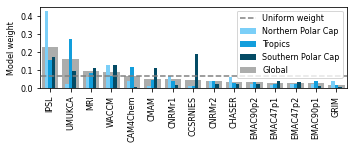

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5.5,1.5))
df_scores.plot.bar(x='mdl_names',y=['Northern Polar Cap', 'Tropics', 'Southern Polar Cap'], color=[cb1, cb2, cb3], ax=ax, zorder=2)
plt.bar(mdl_names, df_scores['Global'].values, color=cb4, alpha=1, label='Global', zorder=1)
plt.xticks(rotation='vertical')
plt.ylabel('Model weight')
plt.xlabel('')
plt.plot([-2,20], [1/15, 1/15], '--',  color='gray' , label='Uniform weight', zorder=3)
plt.legend()
plt.show()

# Model weight in time

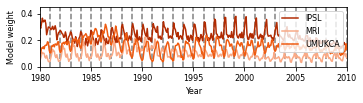

In [12]:
years = np.arange(1980, 2011, 1/12)
import matplotlib.gridspec as gridspec
plt.figure(figsize=(5.5, 1.1))
gridspec.GridSpec(1,4)

# large subplot
plt.subplot2grid((1,4), (0,0), colspan=4, rowspan=1)
plt.plot(years, np.mean(recube(alpha[:,-3]), axis=(1,2)), label=df.columns[12][:-6], color=cr6)
plt.plot(years, np.mean(recube(alpha[:,-2]), axis=(1,2)), label=df.columns[13][:-13], color=cr2)
plt.plot(years, np.mean(recube(alpha[:,-1]), axis=(1,2)), label=df.columns[14][:-11], color=cr7)
for i in range(1980, 2011):
    plt.plot([i,i], [0,0.45],'--',  color='gray', zorder=0)
plt.ylim([0,0.45])
plt.xlabel('Year')
plt.ylabel('Model weight')
plt.xlim([1980, 2010])
plt.xticks([1980, 1985,1990,1995,2000,2005, 2010])
plt.legend()
plt.show()

# Model weights in space

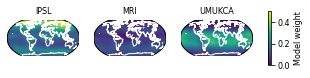

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5.5,1.))

p1 = m.pcolormesh(x, y, split_data(np.mean(recube(alpha[:,-3]), axis=0)), vmin=0, vmax=0.5, ax=axes[0])
m.drawcoastlines(color='white',ax=axes[0])
axes[0].title.set_text(df.columns[12][:-6])

p2 = m.pcolormesh(x, y, split_data(np.mean(recube(alpha[:,-2]), axis=0)), vmin=0, vmax=0.5, ax=axes[1])
m.drawcoastlines(color='white', ax=axes[1])
axes[1].title.set_text(df.columns[13][:-13])

p3 =  m.pcolormesh(x, y, split_data(np.mean(recube(alpha[:,-1]), axis=0)), vmin=0, vmax=0.5, ax=axes[2])
m.drawcoastlines(color='white', ax=axes[2])
axes[2].title.set_text(df.columns[14][:-11])

cb = fig.colorbar(p3, ax=axes.ravel().tolist(), location='right')
cb.set_label('Model weight')

plt.show()

# Uncertainty and noise

In [0]:
# Values need for depicting the masked areas

# Last masked item is at idx 7
lon0 = [-180,180]
lat0 = [(lat[7] + lat[8])/2,(lat[7] + lat[8])/2]
lons0, lats0 = np.meshgrid(lon0, lat0)
x0,y0 = m(lons0, lats0)

# Last masked item is at idx 21
lon1 = [-180,180]
lat1 = [(lat[21] + lat[22])/2,(lat[21] + lat[22])/2]
lons1, lats1 = np.meshgrid(lon1, lat1)
x1,y1 = m(lons1, lats1)

# Last masked item is at idx 43
lon2 = [-180,180]
lat2 = [(lat[43] + lat[44])/2,(lat[43] + lat[44])/2]
lons2, lats2 = np.meshgrid(lon2, lat2)
x2,y2 = m(lons2, lats2)

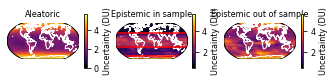

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5.5,1.))

p1 = m.pcolormesh(x, y, split_data(np.mean(noise, axis=0) * (y_max - y_min)/2),cmap=plt.cm.inferno, ax=axes[0], vmin=0., vmax=split_data(epi[-20] * (y_max - y_min)/2).max())
m.drawcoastlines(color='white', ax=axes[0])
axes[0].title.set_text('Aleatoric')
cb = fig.colorbar(p1, ax=axes[0])
cb.set_label('Uncertainty (DU)')

p2 = m.pcolormesh(x, y, split_data(epi[163] * (y_max - y_min)/2),cmap=plt.cm.inferno, ax=axes[1], vmin=split_data(epi[163] * (y_max - y_min)/2).min(), vmax=split_data(epi[-20] * (y_max - y_min)/2).max())
m.drawcoastlines(color='white', ax=axes[1])
m.plot(x0[0], y0[0], color='red', ax=axes[1])
m.plot(x1[0], y1[0], color='red', ax=axes[1])
m.plot(x2[0], y2[0], color='red', ax=axes[1])
axes[1].title.set_text('Epistemic in sample')
cb = fig.colorbar(p2, ax=axes[1])
cb.set_label('Uncertainty (DU)')
# 17
p3 =  m.pcolormesh(x, y, split_data(epi[-20] * (y_max - y_min)/2),cmap=plt.cm.inferno, ax=axes[2], vmin=split_data(epi[163] * (y_max - y_min)/2).min(), vmax=split_data(epi[-20] * (y_max - y_min)/2).max())
m.drawcoastlines(color='white', ax=axes[2])
axes[2].title.set_text('Epistemic out of sample')
cb = fig.colorbar(p3, ax=axes[2])
cb.set_label('Uncertainty (DU)')

plt.show()

# Spatial plots of all models

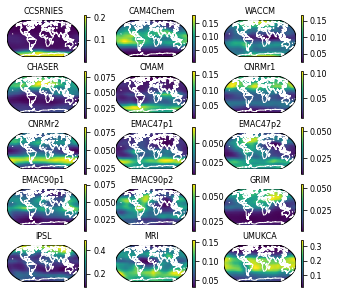

In [16]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(5.5,5.))

for i in range(15):
    a = axes[i//3][i%3]
    p1 = m.pcolormesh(x, y, split_data(np.mean(recube(alpha[:,i]), axis=0)), ax=a, cmap=plt.cm.viridis)
    m.drawcoastlines(color='white',ax=a)
    cb = fig.colorbar(p1, ax=a)
    # cb.set_label('Model weight')
    a.title.set_text(mdl_names[i])

plt.show()

# Weights in time of all models

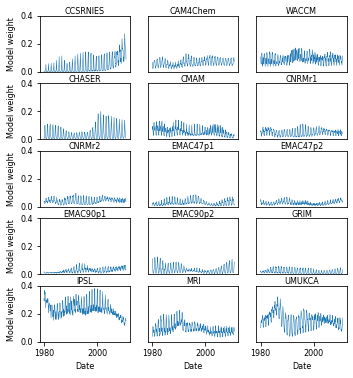

In [17]:
plt.figure(figsize=(5.5,6))
for i in range(15):
    a = alpha[:,i]
    plt.subplot(5,3, i + 1)
    plt.plot(years, np.mean(recube(a), axis=(1,2)), lw=0.5)
    plt.title(mdl_names[i], y=0.92)
    plt.ylim([0,0.4])
    if i % 3 == 0:
        plt.ylabel('Model weight')
    if i >= 12:
        plt.xlabel('Date')
    if i <12:
        plt.xticks([], [])
    if i % 3 != 0:
        plt.yticks([], [])

plt.show()

# Seasonality of weights

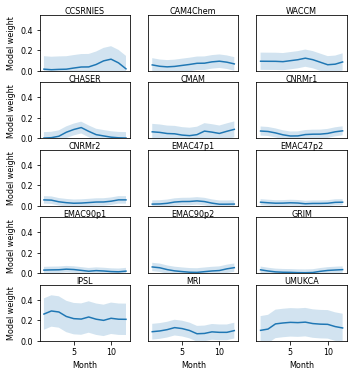

In [18]:
plt.figure(figsize=(5.5,6))
for i in range(15):
    a = alpha[:,i]
    a_mean = np.mean(np.mean(recube(a), axis=(1,2)).reshape(-1, 12), axis=0)
    a_std = np.std(recube(a).reshape(-1, 12), axis=0)

    plt.subplot(5,3, i + 1)
    plt.fill_between(np.arange(12) + 1, a_mean - a_std, a_mean + a_std, alpha=0.2)
    plt.plot(np.arange(12) + 1, a_mean)
    plt.title(mdl_names[i], y=0.91)
    plt.ylim([0,0.55])
    if i % 3 == 0:
        plt.ylabel('Model weight')
    if i >= 12:
        plt.xlabel('Month')
    if i <12:
        plt.xticks([], [])
    if i % 3 != 0:
        plt.yticks([], [])

plt.show()

# BayNNE Bias

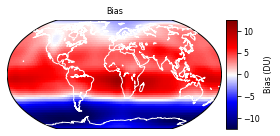

In [33]:
plt.figure(figsize=(5.5,2.))
m.pcolormesh(x, y, dn_u(split_data(np.mean(recube(beta), axis=0))), cmap=plt.cm.seismic, vmin=-12.5, vmax=12.5)
m.drawcoastlines(color='white')
cb = m.colorbar()
cb.set_label('Bias (DU)')
plt.title('Bias')
plt.show()

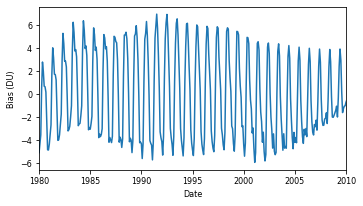

In [38]:
plt.figure(figsize=(5.5,3))
plt.plot(years, dn_u(np.mean(recube(beta), axis=(1,2))))
plt.xlabel('Date')
plt.xlim([1980, 2010])
plt.xticks([1980, 1985,1990,1995,2000,2005, 2010])
plt.ylabel('Bias (DU)')
plt.show()

# Noise

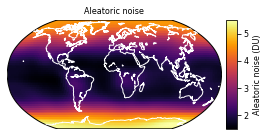

In [39]:
plt.figure(figsize=(5.5,2.))
m.pcolormesh(x, y, dn_u(split_data(np.mean(noise, axis=0))), cmap=plt.cm.inferno)
m.drawcoastlines(color='white')
cb = m.colorbar()
cb.set_label('Aleatoric noise (DU)')
plt.title('Aleatoric noise')
plt.show()

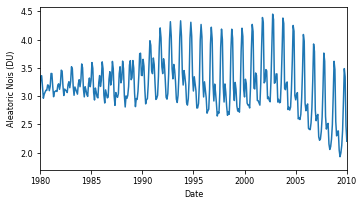

In [40]:
plt.figure(figsize=(5.5,3))
plt.plot(years, dn_u(np.mean(noise, axis=(1,2))))
plt.xlabel('Date')
plt.xlim([1980, 2010])
plt.xticks([1980, 1985,1990,1995,2000,2005, 2010])
plt.ylabel('Aleatoric Nois (DU)')
plt.show()

# Epistemic unertainty

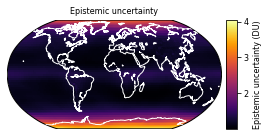

In [41]:
plt.figure(figsize=(5.5,2.))
m.pcolormesh(x, y, dn_u(split_data(np.mean(epi, axis=0))), cmap=plt.cm.inferno)
m.drawcoastlines(color='white')
cb = m.colorbar()
cb.set_label('Epistemic uncertainty (DU)')
plt.title('Epistemic uncertainty')
plt.show()

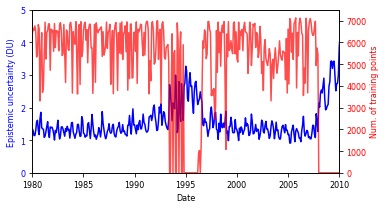

In [50]:
plt.figure(figsize=(5.5,3))
plt.plot(years, dn_u(np.mean(epi, axis=(1,2))), zorder=20, color='blue')
plt.xlabel('Date')
plt.xlim([1980, 2010])
plt.xticks([1980, 1985,1990,1995,2000,2005, 2010])
plt.ylabel('Epistemic uncertainty (DU)', color='blue')
plt.gca().tick_params(axis='y', labelcolor='blue')
plt.ylim([0,5])

ax2 = plt.gca().twinx()
ax2.plot(years, np.sum(recube(df['train_mask'].values), axis=(1,2)), color='red', zorder=-100, alpha=0.7)
ax2.set_ylabel('Num. of training points', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.ylim([0,7500])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()